## Project: A review of Airbnb Data In London, UK.

### Author: Ben Farrell
### Date: 22/05/2020

## Table of Contents
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#lib">Import Libraries</a></li>
    <li><a href="#Gather">Gathering Data</a></li>
    <li><a href="#Assess">Assessing</a></li>
    <li><a href="#Cleaning">Cleaning</a></li>
    <li><a href="#eda">Exploratory Data Analysis (EDA)</a></li>
        <ol type='1'>
            <li><a href="#PriceYr">Seasonal Variation in Price</a></li>
            <li><a href="#PriceNeigh">Price Range per Neighbourghood</a></li>
            <li><a href="#ValNeigh">Value Range per Neighbourghood</a></li>
            <li><a href="#covid">Comparision of bookings between 2019 and 2020 to Infer Impact of Covid</a></li>
        </ol>
    <li><a href="#conclusion">Conclusion</a></li>
    <li><a href="#ref">References</a></li>  
</ol>

<a href="#intro"></a>
## Introduction

Data was collected from [InsideAirbnb](http://insideairbnb.com/get-the-data.html)

The data consists of information regarding property listings, reviews, and calendars outlining occupancy.

From this analysis I hope to determine a better understand of seasonal variation in letting prices, neighbourhood effects of price and perceived customer value and finally the impact of covid on the letting sector.

<a id="lib"></a>
## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from scipy import stats
import re
import calendar
import geopandas as gpd
import adjustText as aT

%matplotlib inline

In [3]:
#Set seaborn colour palette to base 
base = sns.color_palette()[0]

<a id="Gather"></a>
## Gathering Data

In [4]:
#Calendar data
cal2020 = pd.read_csv('calendar.csv.gz')

In [5]:
cal2020.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,140518,2020-04-17,f,$60.00,$60.00,1.0,365.0
1,13913,2020-04-16,f,$49.00,$49.00,1.0,29.0
2,13913,2020-04-17,f,$49.00,$49.00,1.0,29.0
3,13913,2020-04-18,f,$49.00,$49.00,1.0,29.0
4,13913,2020-04-19,t,$49.00,$49.00,1.0,29.0


In [6]:
#Calendar 2019 Data
cal2019 = pd.read_csv('calendar_2019.csv')

In [7]:
cal2019.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13913,2019-04-11,f,$50.00,$50.00,1.0,29.0
1,13913,2019-04-12,f,$50.00,$50.00,1.0,29.0
2,13913,2019-04-13,f,$50.00,$50.00,1.0,29.0
3,13913,2019-04-14,f,$50.00,$50.00,1.0,29.0
4,13913,2019-04-15,f,$50.00,$50.00,1.0,29.0


In [12]:
#Listing data
listings = pd.read_csv('listings.csv.gz')

/Users/benfarrell/anaconda3/envs/data1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<a id="Assess"></a>
## Assessing

Check for missing data in 3 data sets

In [8]:
#Calendar Missing Data
100*cal2020.isna().sum()/cal2020.shape[0]

listing_id        0.000000
date              0.000000
available         0.000000
price             0.000086
adjusted_price    0.000086
minimum_nights    0.003363
maximum_nights    0.003363
dtype: float64

In [9]:
#Calendar Missing Data
100*cal2019.isna().sum()/cal2019.shape[0]

listing_id        0.000000
date              0.000000
available         0.000000
price             0.000052
adjusted_price    0.000052
minimum_nights    0.007322
maximum_nights    0.007322
dtype: float64

In [10]:
#since there is so little missing data, dropping entire rows with missing data will
#make little impact on overall analysis 
cal2020.dropna(axis=0,inplace=True)
cal2019.dropna(axis=0,inplace=True)

In [13]:
#Listing Missing Data
(100*listings.isna().sum()/listings.shape[0]).sort_values(ascending=False)[:20]

neighbourhood_group_cleansed    100.000000
thumbnail_url                   100.000000
xl_picture_url                  100.000000
medium_url                      100.000000
jurisdiction_names               99.998842
license                          99.744089
square_feet                      99.562287
monthly_price                    94.643229
weekly_price                     92.483615
notes                            61.881933
access                           47.685217
host_about                       42.697839
house_rules                      42.642257
interaction                      41.340698
host_response_rate               38.079854
host_response_time               38.079854
transit                          36.337108
neighborhood_overview            35.531161
security_deposit                 34.370875
space                            30.454619
dtype: float64

In [14]:
#Drop columns with more than 75% of data missing.
#This is appropriate since these features are of low improtance to analysis
listings.drop(columns=['neighbourhood_group_cleansed',
                       'thumbnail_url',
                       'xl_picture_url',
                       'medium_url',
                       'jurisdiction_names',
                       'license',
                       'square_feet',
                       'monthly_price',
                       'weekly_price',
                      ],inplace=True)

In [15]:
#Select Relevant features to review
features = (['id',
             'listing_url',
             'scrape_id',
             'name',
             'summary',
             'experiences_offered',
             'neighborhood_overview',
             'neighbourhood_cleansed',
             'zipcode',
             'market',
             'property_type',
             'room_type',
             'bathrooms',
             'bedrooms',
             'amenities',
             'price',
             'cleaning_fee',
             'has_availability',
             'review_scores_rating',
             'review_scores_accuracy',
             'review_scores_cleanliness',
             'review_scores_communication',
             'review_scores_location',
             'review_scores_value'])

In [16]:
listings = listings[features]

<a id='cleaning'></a>
## Cleaning

From Calendar the features to address are:

1. date stores as object - convert to datetime
2. price as string - convert to numeric 
3. adjusted price as string - convert to numeric

From listings there are few items to address:

1. Price - This is stored as object and also has $ included. This should be changed to float
2. Zipcode is an object and contains full Zipcode e.g SE15 8LW. I'll extract the first portion to get the area and then assign this to a categorical type


In [17]:
#Convert to datetime
cal2020['date'] = pd.to_datetime(cal2020['date'])
cal2019['date'] = pd.to_datetime(cal2019['date'])

In [18]:
#Extract Month from datetime
cal2020['month'] = cal2020['date'].apply(lambda x: x.month)
cal2019['month'] = cal2019['date'].apply(lambda x: x.month)

In [19]:
#Change Price to Int Function
def cleanPriceCal(row):
    return int(''.join(row[1:-3].split(',')))

In [20]:
#Apply to price column
cal2020['price'] = cal2020['price'].apply(cleanPriceCal)

In [21]:
cal2019['price'] = cal2019['price'].apply(cleanPriceCal)

In [22]:
#Apply to adjusted price column
cal2020['adjusted_price'] = cal2020['adjusted_price'].apply(cleanPriceCal)
cal2019['adjusted_price'] = cal2019['adjusted_price'].apply(cleanPriceCal)

In [23]:
#Drop unnecessary features in calendar data
cal2020.drop(columns=['minimum_nights','maximum_nights'],inplace=True)

In [24]:
#Drop unnecessary features in calendar data
cal2019.drop(columns=['minimum_nights','maximum_nights'],inplace=True)

In [25]:
#Take a copy of listing dataset before cleaning
lst_clean = listings.copy()

In [26]:
#Make price integer
lst_clean['Price'] = lst_clean['price'].apply(cleanPriceCal)

In [27]:
lst_clean['Price'].describe()

count    86358.000000
mean       129.610725
std        289.484146
min          0.000000
25%         47.000000
50%         83.000000
75%        140.000000
max      19985.000000
Name: Price, dtype: float64

In [28]:
lst_clean.drop(columns=['price'],inplace=True)

In [29]:
#Lets drop entries with price equal to zero
lst_clean.drop(lst_clean['Price'][lst_clean['Price']==0].index,inplace=True)

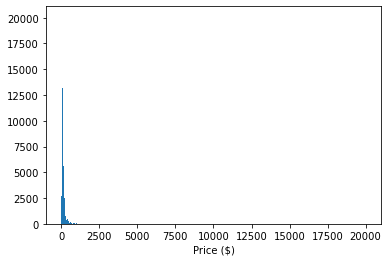

In [30]:
binsize = np.arange(0,lst_clean['Price'].max()+25,25)

plt.hist(lst_clean['Price'],bins=binsize)
plt.xlabel('Price ($)');

I can see that the majority of the data price data is less than $1000 per night.

The max values of $19985 need to be investigated to see if they are erronous data or just really expensive places

I'll explore upper and lower range

In [31]:
lst_clean[lst_clean['Price'] == 19985][['id','listing_url','name','Price']]

,id,listing_url,name,Price
57893,33514904,https://www.airbnb.com/rooms/33514904,Gloucester Place - F5 - 140,19985
57952,33539707,https://www.airbnb.com/rooms/33539707,Park West - F8 - Block 1,19985
62919,35783261,https://www.airbnb.com/rooms/35783261,Westbourne Terrace-26,19985
64672,36506408,https://www.airbnb.com/rooms/36506408,Queens Court-Flat 92A,19985
67506,37617736,https://www.airbnb.com/rooms/37617736,Norfolk Place- 4A,19985
68483,37986151,https://www.airbnb.com/rooms/37986151,Norfolk Place - 5A,19985


These properties were checked and prices have not been extracted properly. These rows will be dropped.

In [32]:
#Drop rows with incorrect price data extracted
lst_clean.drop(lst_clean['Price'][lst_clean['Price']==19985].index,inplace=True)

In [33]:
#Check next largest price
lst_clean[lst_clean['Price'] > 10000][['id','listing_url','name','Price']]

,id,listing_url,name,Price
58123,33601103,https://www.airbnb.com/rooms/33601103,"The Colonnades, Porchester Square - F115, 34",12345


Despite being £12K per night, this advert is correctly listed. Perhaps this is an error on the site and shoudl actually be listed cheaper.

In [35]:
#check properties at lowest range - Not ok. Error with scrapping when checked against URL. Spot check only
lst_clean[(lst_clean['Price'] < 10)][['id','listing_url','name','Price']]

,id,listing_url,name,Price
10117,7890569,https://www.airbnb.com/rooms/7890569,1.4 Enjoy London For Less,9
13421,10061925,https://www.airbnb.com/rooms/10061925,February Sale Up To 30%,9
14692,11267251,https://www.airbnb.com/rooms/11267251,PRIVATE ROOM IN LONDON (I),9
14780,11324083,https://www.airbnb.com/rooms/11324083,PRIVET ROOM IN LONDON (III),9
14786,11332274,https://www.airbnb.com/rooms/11332274,-20 per night for 2 persons (V),9
14807,11348431,https://www.airbnb.com/rooms/11348431,PRIVATE ROOM IN LONDON (III),9
19203,14009628,https://www.airbnb.com/rooms/14009628,Joslings Place,8
19204,14009764,https://www.airbnb.com/rooms/14009764,Joslings Place,8
21034,15186185,https://www.airbnb.com/rooms/15186185,Perfect Room in London,9
23486,16567689,https://www.airbnb.com/rooms/16567689,Perfect Master Bedroom in London,9


In [36]:
#check properties at the next lowest range - These are ok. Spot checked with url
lst_clean[(lst_clean['Price'] > 10) & (lst_clean['Price'] < 20)][['id','listing_url','name','Price']]

,id,listing_url,name,Price
95,85582,https://www.airbnb.com/rooms/85582,Room to let,15
508,388700,https://www.airbnb.com/rooms/388700,"MORDEN London Zone 4, Bright Single Room",12
636,422748,https://www.airbnb.com/rooms/422748,"Lovely, Comfi and Cozy room for two",17
900,514476,https://www.airbnb.com/rooms/514476,"A lovely, clean place to stay",19
1089,574475,https://www.airbnb.com/rooms/574475,Private room nr Airport (2)7,18
...,...,...,...,...
86074,43113509,https://www.airbnb.com/rooms/43113509,Couch in Flatshare,12
86173,43133614,https://www.airbnb.com/rooms/43133614,Lovely bedroom in Borough,19
86177,43136305,https://www.airbnb.com/rooms/43136305,Daré To Dream,18
86180,43136485,https://www.airbnb.com/rooms/43136485,Doce Vita,18


After spot checking the properties in the price bracket less than \$10 per night I can say with some confidence that there has been an issue with the data collected.

Many properties listed at USD8 are actually listed for USD18. Since there are only 46 properties of this type, I will simply delete these from the dataset.

In [37]:
#Dropped values with price less than $10, these were incorrectly scrapped.
lst_clean.drop(lst_clean[(lst_clean['Price'] < 10)][['id','listing_url','name','Price']].index,inplace=True)

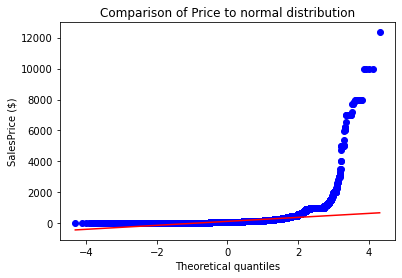

In [245]:
#When compared to a normal distribution,
#it is obvious that SalesPrice in the current form doesn't fit a normal dist profile
fig = plt.figure()
res = stats.probplot(lst_clean['Price'],plot=plt)
plt.ylabel('SalesPrice ($)')
#plt.ticks([0,20,50,100,200,500,1000],[0,20,50,100,200,500,1000])
plt.title('Comparison of Price to normal distribution')
plt.show()

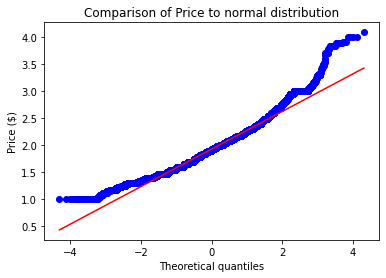

In [246]:
#aligns better with normal distribution when on a log scale
lst_clean['logPrice'] = np.log10(lst_clean['Price'])
fig = plt.figure()
res = stats.probplot(lst_clean['logPrice'],plot=plt)
plt.ylabel('Price ($)')
#plt.yticks([0,20,50,100,200,500,1000],[0,20,50,100,200,500,1000])
plt.title('Comparison of Price to normal distribution')
plt.show()

Price alone isn't the best metric to comapre properties. 

I'll create a feature which is price per room per night. This will give a fairer comparison between different size properties.

In [40]:
#Create price per room feature
#Allow for bedsits which have zero bedrooms.
lst_clean['ppr'] = lst_clean.apply(lambda x: x['Price'] if x['bedrooms'] < 2 else x['Price']/x['bedrooms'],axis=1)

In [41]:
lst_clean.ppr.describe()

count    86148.000000
mean        87.449887
std        168.349672
min          2.458333
25%         40.000000
50%         61.666667
75%         97.500000
max       9999.000000
Name: ppr, dtype: float64

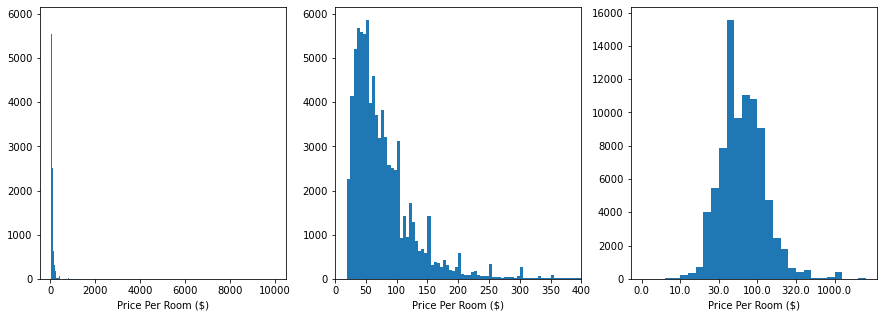

In [42]:
#Look at the disribution of price per room
plt.figure(figsize=(15,5))
binsize = np.arange(20,lst_clean['ppr'].max(),5)

plt.subplot(131)
plt.hist(lst_clean['ppr'],bins=binsize)
plt.xlabel('Price Per Room ($)')

plt.subplot(132)
plt.hist(lst_clean['ppr'],bins=binsize)
plt.xlim(0,400)
plt.xlabel('Price Per Room ($)');

plt.subplot(133)
lst_clean['logPPR'] = np.log10(lst_clean['ppr'])
binsize = np.arange(0.5,3.5,0.1)
plt.hist(lst_clean['logPPR'],bins=binsize)
plt.xticks(np.arange(0.5,3.5,0.5), [0.0, 10.0, 30.0, 100.0, 320.0, 1000.0])
plt.xlabel('Price Per Room ($)');

Price per room follows a relatively normal distribution when transformed onto a log scale.

In [43]:
#Zip Code Cleaning
print('Only {:.2f}% of dataset is missing zipcode info'.format(100*lst_clean.zipcode.isna().sum()/lst_clean.shape[0]))

Only 2.25% of dataset is missing zipcode info


Since only 2% of the dataset is missing zipcode info, I'll drop rows with missing data. If I was spending more time on this project I would potentially look into imputing the postcode from the street name data.

In [44]:
#Drop Rows with No Zipcode.
lst_clean.drop(lst_clean['zipcode'][lst_clean['zipcode'].isna()].index,inplace=True)

In [45]:
def postcode(row):
    pat = r'(([a-pr-uwyzA-PR-UWYZ][a-hk-yA-HK-Y]?[0-9][0-9]?)|(([a-pr-uwyzA-PR-UWYZ][0-9][a-hjkstuwA-HJKSTUW])|([a-pr-uwyzA-PR-UWYZ][a-hk-yA-HK-Y][0-9][abehmnprv-yABEHMNPRV-Y])))'
    try:
        return (re.compile(pat).split(row['zipcode'])[1]).upper()
    except:
        return 'N/A'

In [46]:
lst_clean['postcode'] = lst_clean.apply(postcode,axis=1)

In [47]:
lst_clean[lst_clean['postcode']=='N/A'][['zipcode','postcode']]

,zipcode,postcode
107,SW 18 3HF,N/A
832,Kings cross,N/A
3188,SW$ 9AB,N/A
3335,N/a,N/A
4465,London,N/A
7786,SE 21 8NZ,N/A
8685,NI 9JS,N/A
9702,Enfield,N/A
11651,N 7 0ND,N/A
12441,[no name],N/A


In [48]:
#change a few postcodes that failed to convert
lst_clean.at[107,'postcode'] = 'SW18'
lst_clean.at[7786,'postcode'] = 'SW21'
lst_clean.at[9702,'postcode'] = 'N14'
lst_clean.at[11651,'postcode'] = 'N7'
lst_clean.at[13531,'postcode'] = 'E14'

In [49]:
#Drop remaining rows where postcode data is missing
lst_clean.drop(lst_clean['postcode'][lst_clean['postcode'] == 'N/A'].index,inplace=True)

### Export the cleaned data to CSVs

In [97]:
cal2020.to_csv('Cal2020_Clean.csv')

In [98]:
cal2019.to_csv('Cal2019_Clean.csv')

In [99]:
lst_clean.to_csv('listing_Clean.csv')

In [9]:
cal2020 = pd.read_csv('Cal2020_Clean.csv')

In [11]:
cal2020.drop(columns=['Unnamed: 0'],inplace=True)

In [12]:
cal2019 = pd.read_csv('Cal2019_Clean.csv')
cal2019.drop(columns=['Unnamed: 0'],inplace=True)

In [13]:
lst_clean = pd.read_csv('listing_Clean.csv')
lst_clean.drop(columns=['Unnamed: 0'],inplace=True)

<a id='eda'></a>
## Exploratory Data Analysis (EDA)

### What is the structure of your dataset?

Calendar Data for 2020 and 2019 both have 6 features.

2020 has 31,521,054 entries.
2019 has 29,077,102 entries.

This contains booking details for year ahead for each property id. This data will be used to look at the difference in activity with Covid-19.

The listing data set has 27 features and 84,329 entries. This data will be used to understand which neighbourhoods and postcode provide the cheapest and most expensive accommodation.


### What is/are the main feature(s) of interest in your dataset?

1. I'd like investigate the seasonal price variation in the airbnb data so i can identify the cheapest and most expensive seasons. I'm expecting to see rises in prices and activity around the regular holiday, Easter, Summer and Christmas/NYE.

2. I would also like to investigate which neighbourhoods demand the highest nightly price for room. I'm expecting central zones to be the highest.

3. I will also investigate the impact of neighbourhood on the Perceived Value the customers felt they experienced with their booking. This data will be taken from the reviews.

3. Additionally I would like to review the impact of Covid-19 on the occupancy levels. With government imposed bans I would expect the see activity significantly reduced through April, March and May. However, I would like to see if we can gather any insights from booking data which will suggest what activity levels will be like going forward. This will require comparison of data between 2019 and 2020.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Calendar availability and price data will be key to answering Questions 1 and 3. Listing data on price and location will be required for Question 2, but this will have to be merged/joined with calendar data to assess occupancy rates.

<a id="PriceYr"></a>
### Seasonal Price Variation

Check to see if there is an change in the mean price over the year. I'm expecting to see rises in prices and activity aroudn the regular holiday, Easter, Summer and Christmas/NYE.

In [50]:
c20 = cal2020.groupby('month').mean()['price']
c19 = cal2019.groupby('month').mean()['price']

In [51]:
ind = np.arange(len(c20))
width = 0.35

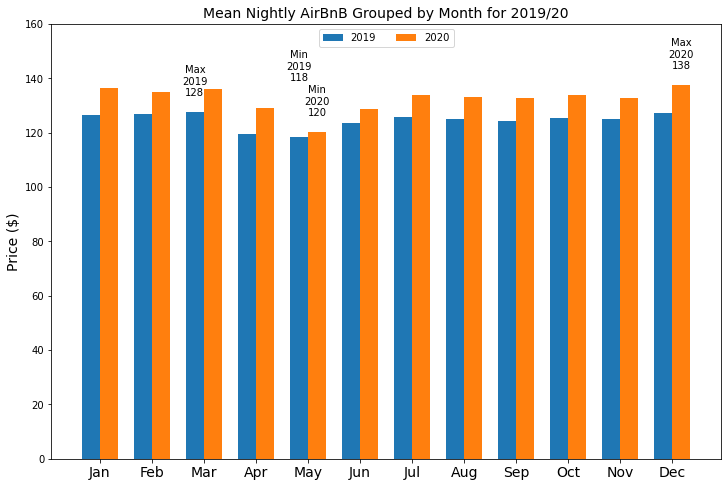

In [249]:
fig, ax = plt.subplots(1,figsize=(12,8))
bar2 = ax.bar(ind - width/2, c19, width, label='2019')
bar1 = ax.bar(ind + width/2, c20, width, label='2020')
bars = bar1 + bar2
ax.set_ylabel('Price ($)',fontsize=14)
ax.set_title('Mean Nightly AirBnB Grouped by Month for 2019/20',fontsize=14)
ax.set_xticks(ind)
plt.ylim(0,160)
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1,13)],fontsize=14)
ax.legend(loc='upper center',ncol=2)


#Add label to max and min
min_19, max_19 = c19.min(), c19.max()
min_20, max_20 = c20.min(), c20.max()

texts = []
#background
props = dict(facecolor='linen', alpha=0.9)

for rect in ax.patches:
    height = rect.get_height()
    if height == min_19:        
        texts.append(ax.text(rect.get_x() + rect.get_width() / 2, height + 20,
                'Min\n2019\n{:.0f}'.format(height), ha='center', va='bottom'))
    elif height == min_20:
        texts.append(ax.text(rect.get_x() + rect.get_width() / 2, height + 5,
                'Min\n2020\n{:.0f}'.format(height), ha='center', va='bottom'))
    elif height == max_19:
        texts.append(ax.text(rect.get_x() + rect.get_width() / 2, height + 5,
                'Max\n2019\n{:.0f}'.format(height), ha='center', va='bottom'))
    elif height == max_20:
        texts.append(ax.text(rect.get_x() + rect.get_width() / 2, height + 5,
                'Max\n2020\n{:.0f}'.format(height), ha='center', va='bottom'))
        
#aT.adjust_text(texts, add_objects=bars, autoalign='y', expand_objects=(0.1, 1),
#            only_move={'points':'', 'text':'y', 'objects':'y'}, force_text=.75, force_objects=0.1,
#            arrowprops=dict(arrowstyle="simple, head_width=0.25, tail_width=0.05", color='grey', lw=0.5, alpha=0.5))


# this will save the figure as a high-res png. you can also save as svg
fig.savefig('Mean_Monthly_RoomPrice.png', dpi=900)

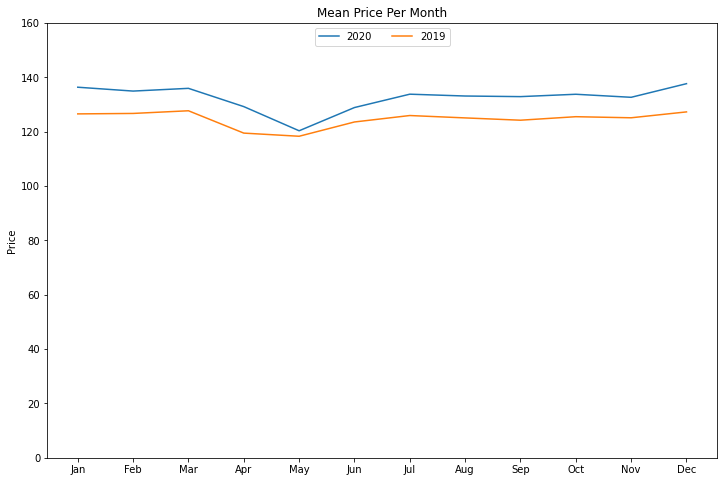

In [94]:
plt.subplots(figsize=(12,8))

c20.plot(kind='line',label='2020')
c19.plot(kind='line',label='2019')
plt.ylim(0,160)

plt.xticks(np.arange(1,13), [calendar.month_abbr[i] for i in range(1,13)])
plt.legend(loc='upper center',ncol=2)
plt.ylabel('Price')
plt.xlabel('')
plt.title('Mean Price Per Month');

### Seasonal Price Variation Summary

Both 2019 and 2020 show some seasonal variation, however these changes are not entirely consistent year to year. 

Both 2019 and 2020 data suggested that on average May was the cheapest month to visit London.

The most expensive month on average during 2019 was March with an average listing price of USD128. The most expensive month on average in the 2020 data is expected to be December with an average listing price of USD138.

That is a considerable difference in price for 2020 data. A 15% difference depending on the month visited. We should take into account that during May there was guidance not to travel due to covid-19.

<a id="PriceNeigh"></a>
### Price Range per Neighbourhood

Now to review which neighbourhoods have the highest average price. This will be done a per rooms basis.

A review of the data shows that the majority of listings are in central London Zone 1. Especially Westminster and Tower Hamlets.

In [131]:
lst_clean.review_scores_value.value_counts()

10.0    30577
9.0     22354
8.0      6072
7.0      1061
6.0       936
2.0       324
4.0       211
5.0       128
3.0         9
Name: review_scores_value, dtype: int64

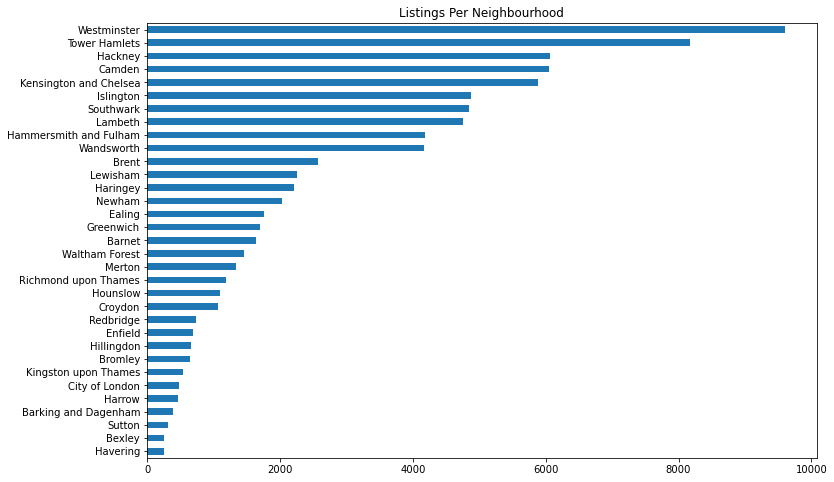

In [247]:
plt.figure(figsize=[12,8])
plt.title('Listings Per Neighbourhood')
lst_clean.neighbourhood_cleansed.value_counts(ascending=True).plot(kind='barh');

In [154]:
lst_clean.groupby('neighbourhood_cleansed').mean()['Price'].sort_values()

neighbourhood_cleansed
Bexley                     57.396887
Croydon                    59.163208
Barking and Dagenham       59.391645
Bromley                    65.746106
Enfield                    66.742402
Havering                   67.666667
Hillingdon                 68.639695
Lewisham                   70.531651
Waltham Forest             71.101858
Redbridge                  71.123306
Harrow                     78.634409
Kingston upon Thames       82.953445
Newham                     83.730580
Sutton                     85.317152
Ealing                     90.354875
Greenwich                  90.764223
Haringey                   91.924229
Barnet                     92.848540
Hackney                    94.673099
Tower Hamlets              96.178969
Lambeth                   100.814721
Brent                     102.075787
Hounslow                  108.326027
Merton                    116.867614
Islington                 118.092175
Wandsworth                124.432445
Southwark      

In [19]:
#import geopandas data for London
fp = '/Users/benfarrell/Documents/Udacity/DataScience/1_DataScienceProcess/BlogPost/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)

In [22]:
map_df

,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry,NameShort
NAME,,,,,,,,
Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16...",Kingston
Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15...",Croydon
Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15...",Bromley
Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17...",Hounslow
Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18...",Ealing
Havering,E09000016,11445.735,210.763,F,None,None,"POLYGON ((549893.900 181459.800, 549894.600 18...",Havering
Hillingdon,E09000017,11570.063,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510615.200 19...",Hillingdon
Harrow,E09000015,5046.330,0.000,F,None,None,"POLYGON ((510599.800 191689.500, 510660.000 19...",Harrow
Brent,E09000005,4323.270,0.000,F,None,None,"POLYGON ((525201.000 182512.600, 525181.500 18...",Brent


In [20]:
#Create abbr name
map_df['NameShort'] = map_df.NAME.apply(lambda x: x.split(' ')[0])
map_df.set_index('NAME',inplace=True)

In [23]:
#Group Price Per Room and Price
price = lst_clean.groupby('neighbourhood_cleansed').mean()['Price'].to_frame()
pricePR = lst_clean.groupby('neighbourhood_cleansed').mean()['ppr'].to_frame()
value = lst_clean.groupby('neighbourhood_cleansed').mean()['review_scores_value'].to_frame()

In [24]:
#Combine map data and listing data
combined = pd.merge(map_df,price,left_index=True,right_index=True)
combined = pd.merge(combined,pricePR,left_index=True,right_index=True)
combined = pd.merge(combined,value,left_index=True,right_index=True)

In [25]:
#Set centroid of each neighbourhood
combined['centroid']=combined['geometry'].centroid

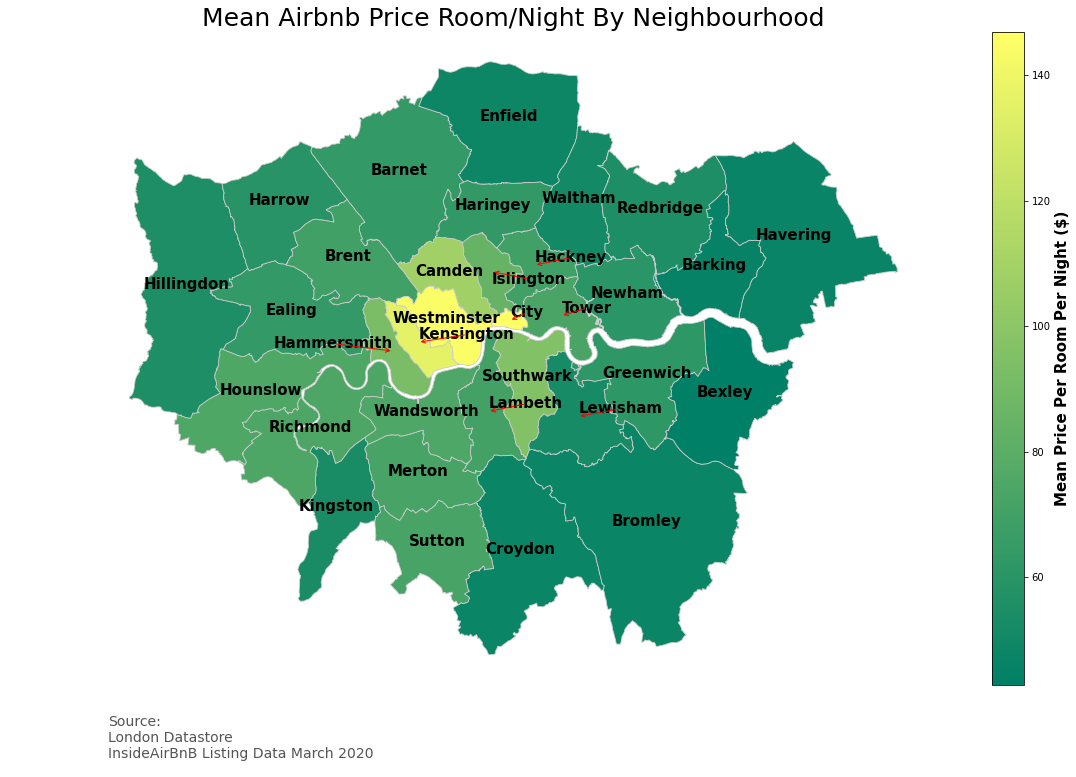

In [45]:
#Plot Neighbourhoods with PricePerRoom on Heatmap Scale
variable = 'ppr'

# set the range for the choropleth
vmin, vmax = combined.ppr.min(), combined.ppr.max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))

# create map
combined.plot(column=variable, cmap='summer', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Mean Airbnb Price Room/Night By Neighbourhood', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

#Create list of labels for the neighbourhoods
texts = []
#props = dict(facecolor='white', alpha=0.9)
for x, y, label in zip(combined.centroid.x, combined.centroid.y, combined.NameShort):
    #Change colour for high values if clashes with colour format
    if label in ['Kensington','City','Islington','Lambeth','Hackney','Lewisham','Tower','Hammersmith']:
        #apply label to plot
        texts.append(plt.text(x,y,label,color='black',fontweight='bold',horizontalalignment='center',fontsize=15))
    else:
        plt.text(x,y,label,color='black',fontweight='bold',horizontalalignment='center',fontsize=15)

#Adjust labels to ensure they don't overlap
#aT.adjust_text(texts,arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))
aT.adjust_text(texts, force_points=0.1, force_text=0.1, expand_points=(1,1), expand_text=(1,1),
               horizontalalignment = 'center', arrowprops=dict(arrowstyle="->", color='red', lw=1))

# create an annotation for the  data source
ax.annotate('Source:\nLondon Datastore\nInsideAirBnB Listing Data March 2020',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=14, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='summer', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('Mean Price Per Room Per Night ($)',fontweight='bold',fontsize='15')

# this will save the figure as a high-res png. you can also save as svg
fig.savefig('Price_MedRes.png', dpi=1000)

### Summary of Price Range Per Neighbourhoods

- The data clearly shows that the price per room increases significantly as you approach Central London.

- Unsurprising The City of London, Westminster and Kensington and Chelsea record the highest averages for nightly price per room. 
- The highest being The City of London at USD146 on average.
- Brexely in East London has the cheapest average at USD43 per night.
- There is a definite trend of higher prices in West London and Cheaper Prices in East London, which is to be expected as West London is traditionally seem as more 'Upper Class'.

<a id="ValNeigh"></a>
### Value Range per Neighbourghood

Let's have a look at the perceived value customers felt they experienced during their stay. This is ranked on a scale of 1 (Worst) - 10 (Best). Data is collected from listing review value.

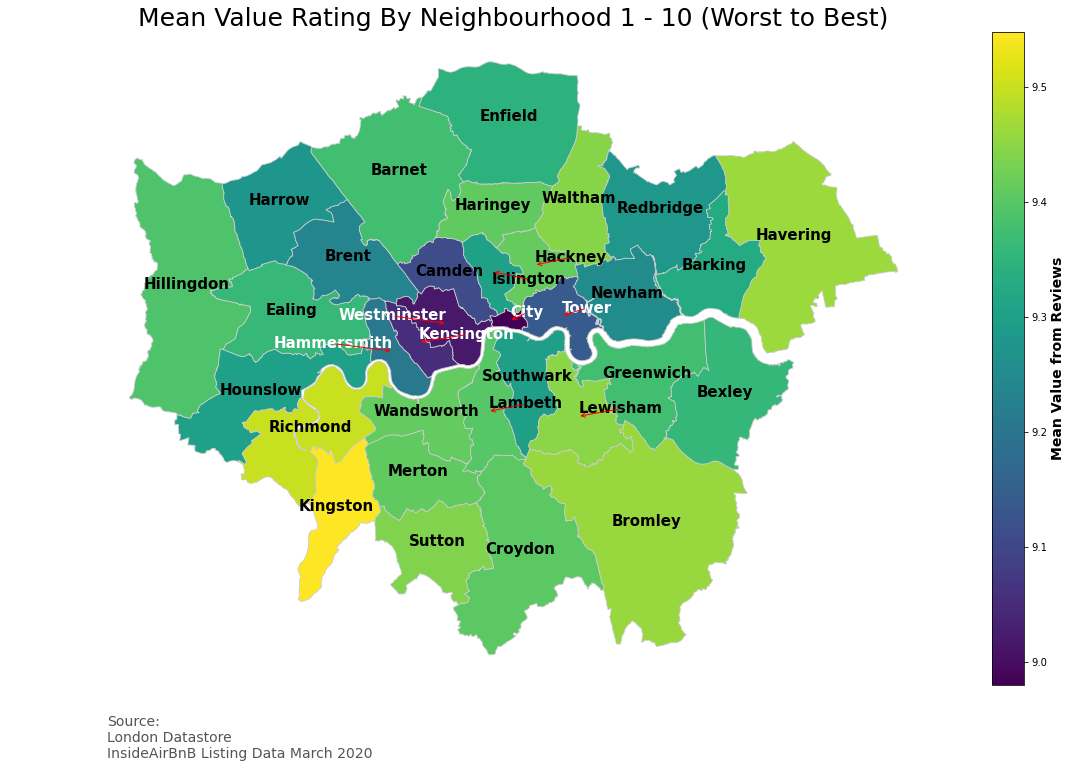

In [46]:
#Plot Neighbourhoods with PricePerRoom on Heatmap Scale
variable = 'review_scores_value'

# set the range for the choropleth
vmin, vmax = combined[variable].min(), combined[variable].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))

# create map
combined.plot(column=variable, cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Mean Value Rating By Neighbourhood 1 - 10 (Worst to Best)', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

#Create list of labels for the neighbourhoods
texts = []
for x, y, label in zip(combined.centroid.x, combined.centroid.y, combined.NameShort):
    #Change colour for high values if clashes with colour format
    if label in ['Kensington','Hammersmith','City','Tower','Westminster']:
        #apply label to plot
        texts.append(plt.text(x,y,label,color='white',fontweight='bold',horizontalalignment='center',fontsize=15))
    elif label in ['Islington','Lambeth','Hackney','Lewisham']:
        texts.append(plt.text(x,y,label,color='black',fontweight='bold',horizontalalignment='center',fontsize=15))
    else:
        plt.text(x,y,label,color='black',fontweight='bold',horizontalalignment='center',fontsize=15)

#Adjust labels to ensure they don't overlap
#aT.adjust_text(texts,arrowprops=dict(arrowstyle="->", color='grey', lw=0.5))
aT.adjust_text(texts, force_points=0.1, force_text=0.1, expand_points=(1,1), expand_text=(1,1),
               horizontalalignment = 'center', arrowprops=dict(arrowstyle="->", color='red', lw=1))

# create an annotation for the  data source
ax.annotate('Source:\nLondon Datastore\nInsideAirBnB Listing Data March 2020',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=14, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('Mean Value from Reviews',fontweight='bold',fontsize='14')

# this will save the figure as a high-res png.
fig.savefig('Value_Med_Res.png', dpi=1000)

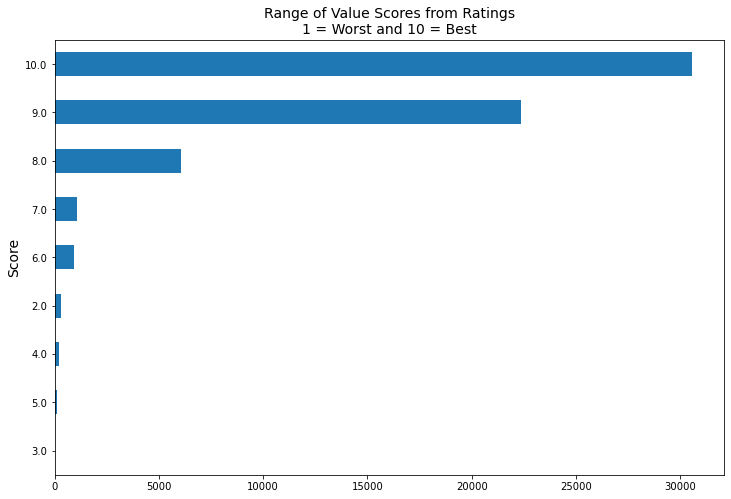

In [206]:
fig, ax = plt.subplots(figsize=(12,8))
plt.title('Range of Value Scores from Ratings\n1 = Worst and 10 = Best', fontsize=14)
plt.ylabel('Score',fontsize=14)
lst_clean.review_scores_value.value_counts(ascending=True).plot(kind='barh');

### Summary of Price Range Per Neighbourhoods

The perceived value the customers experienced, which was measured in ratings, painted a slightly different story. The majority of scores were between 9-10 which shows that typically customers feel as though they received good value.

However, looking at this narrow band of scores shows that on average, customers who stayed closer to Central London (Kensington, Westminster, City of London, Hammersmith & Fulham) felt as though they received slightly less value from their booking. This aligns well with what would be expected.

Customers in Central London pay significantly more, but only experience marginal benefits from being in Central. This is partly because Public Transport is so good in London, which means that staying slightly further out of town makes little impact. Additionally, Central London tends to be more congested and chaotic. We don't have the data to evaluate accommodation size on a $/sq ft basis, but I would image that property size will decrease considerably in Central London too which I believe would be a good indicator of "Value".

Customers staying in the West London boroughs of Richmond Upon Thames and Kingston Upon Thames recorded the highest levels of Value. This area of London is certainly very beautiful and typically quite gentrified. It also has excellent travel connections into Waterloo in Central London.

<a id="covid"></a>
### Comparision of bookings between 2019 and 2020 to Infer Impact of Covid

In [227]:
#Add in True/False for Booked 2020 Data
cal2020['occupancy'] = cal2020.available.apply(lambda x: True if x == 'f' else False)

In [228]:
#Add in True/False for Booked 2019 Data
cal2019['occupancy'] = cal2019.available.apply(lambda x: True if x == 'f' else False)

In [175]:
cal2020[cal2020['month'] == 10]['listing_id'].nunique()

86358

In [177]:
cal2019[cal2019['month'] == 10]['listing_id'].nunique()

79657

In [233]:
occupancy20 = cal2020.groupby('month').mean()['occupancy']*100

In [234]:
occupancy19 = cal2019.groupby('month').mean()['occupancy']*100

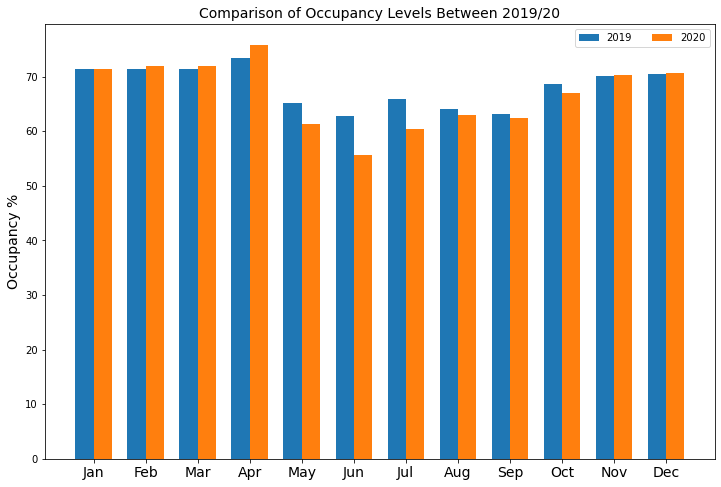

In [238]:
fig, ax = plt.subplots(1,figsize=(12,8))
bar2 = ax.bar(ind - width/2, occupancy19, width, label='2019')
bar1 = ax.bar(ind + width/2, occupancy20, width, label='2020')
bars = bar1 + bar2
ax.set_ylabel('Occupancy %',fontsize=14)
ax.set_title('Comparison of Occupancy Levels Between 2019/20',fontsize=14)
ax.set_xticks(ind)
#plt.ylim(0,160)
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1,13)],fontsize=14)
ax.legend(loc='best',ncol=2,);

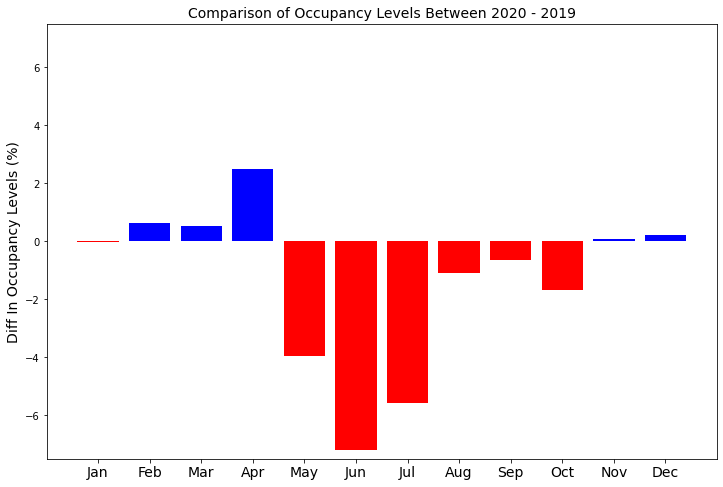

In [251]:
fig, ax = plt.subplots(1,figsize=(12,8))
diff = (occupancy20 - occupancy19).to_frame()
diff['posneg'] = diff.occupancy.apply(lambda x: 'neg' if x < 0 else 'pos')
ax.bar(ind, diff.occupancy, color=diff.posneg.map({'pos': 'b', 'neg': 'r'}))
ax.set_ylabel('Diff In Occupancy Levels (%)',fontsize=14)
ax.set_title('Comparison of Occupancy Levels Between 2020 - 2019',fontsize=14)
ax.set_xticks(ind)
plt.ylim(-7.5,7.5)
ax.set_xticklabels([calendar.month_abbr[i] for i in range(1,13)],fontsize=14)
# this will save the figure as a high-res png.
fig.savefig('MarketOutlook.png', dpi=900)

### Summary of Comparing Bookings for 2019 and 2020 to Infer Impact of Covid-19

> The number of indiviudal listings increased by approximately 10% year-on-year from 2019 to 2020, but the impacts of Covid-19 are evident.

> The first few months showed a slight increase in occupancy levels. Despite Covid-19 being declared a Global Pandemic by the WHO, the AirBnB market showed resiliance.

> But the impact on the booking pipeline is obvious. It will take at least 6 months to rebound to occupancy levels observed in in 2019.

<a id="conclusion"></a>
### Conclusion

**Customer Advice**

After reviewing the data from AirBnB I would give the following guidance to customers...

 - Where possible avoid the Christmas Season as prices in tend to increase at this point. You may end up paying up to 15% more than if you were to visit in May.
 - I would also avoid staying in Central London (Kensington, Westminster, City of London, Hammersmith & Fulham) because you pay a disproportionately higher price. Surrounding neighbourhoods from Central such as Lambeth and Hackney offer the benefit of much cheaper accommodation whilst only being a short bus or tube ride into town.
 - Perceived customer value also increases outside of Central London. If value is what you are seeking, then it would be worth checking out Kingston and Richmond.
 
**Market Outlook**

In terms of a market outlook, the next 6 months look quite tough for Hosts. Comparing the booking pipeline of 2019 to 2020 shows occupancy rates are predicted to be down year-on-year until October. Occupancy levels will fall until June before seeing an uptick. Occupancy level are due to be down 7% in June. 

The data would suggest that this is due to the combined effect of Covid-19 and a 12% increase in lettings on the market. The Government has imposed travel restrictions and recommended that all employees work from home where possible. This has resulted in a significant fall in activity in the Capital. Combining this with the increased supply of accommodation has resulted in an over supply of accommodation which has depreciated occupancy levels.

<a id='Ref'></a>
## References

* 1 - [stackoverflow](https://stackoverflow.com/questions/164979/regex-for-matching-uk-postcodes) - UK Postcode REGEX
* 2 - [InsideAirbnb](http://insideairbnb.com/get-the-data.html) Airbnb Data
* 3 - [London DataStore](https://data.london.gov.uk/dataset/london-borough-profiles) Geometry for London Boroughs
* 4 - [Geopandas Blog Post](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d) Excellent Tutorial for an Introduction to Geopandas